# Calibration of Heston model
- In the following notebook we calibrate the Heston model to option prices and implied volatility

- To obtain Heston price we use: midpoint method, Monte-Carlo method, COS method. 

In [ ]:
import ipywidgets as widgets

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import math
#import pandas as pd
from scipy.stats import norm
from scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from IPython.display import display
%matplotlib inline
import warnings

In [ ]:
#Heston Model's Characteristic Function
def Heston_CF(u, S0, T, r, kappa, nu0, theta, xi, rho):
    alpha = - u**2 / 2 - 1j * u / 2
    beta = kappa - rho * xi * 1j * u
    gamma = xi**2 / 2
    h = np.sqrt(beta**2 - 4 * alpha * gamma)
    rm = (beta - h) / xi**2
    rp = (beta + h) / xi**2
    g = rm / rp
    C = kappa * (rm * T - 2 / xi**2 * np.log((1 - g * np.exp(-h * T)) / (1 - g)))
    D = rm * (1 - np.exp(-h * T)) / (1 - g * np.exp(-h * T))
    cf = np.exp(C * theta + D * nu0 + 1j * u * np.log(S0 * np.exp(r * T)))
    return cf

#Heston Call Price with midpoint rule
def Heston_price(S0, K, T, r, kappa, nu0, theta, xi, rho):
    params = (S0, T, r, kappa, nu0, theta, xi, rho)
    P1 = 0.5
    P2 = 0.5
    umax = 50
    n = 100
    #remark: we may need to increase umax and n if numerical issues,
    #particularly when options are deep OTM
    du = umax / n
    u = du / 2
    for i in range(n):
        temp1 = np.exp(-1j * u * np.log(K)) * Heston_CF(u - 1j, *params) / (1j * u * Heston_CF(-1j, *params))
        temp2 = np.exp(-1j * u * np.log(K)) * Heston_CF(u, *params) / (1j * u)
        P1 = P1 + 1 / np.pi * temp1 * du
        P2 = P2 + 1 / np.pi * temp2 * du
        u = u + du
    price = np.real(S0 * P1 - K * np.exp(-r * T) * P2)
    return price

In [ ]:
#simulation asset prices
def simulate_stock_price(S0, T, r, kappa, nu0, theta, xi, rho, N, nstep):
    # Generate random samples for the underlying asset's returns
    np.random.seed(3)
    dW1 = np.random.normal(size=(N, nstep))
    dW2 = rho * dW1 + np.sqrt(1 - rho**2) * np.random.normal(size=(N, nstep))
    dt = T / nstep
    # Calculate the asset's returns and volatility at each time step
    S = np.empty((N, nstep))
    v = np.empty((N, nstep))
    S[:, 0] = S0
    v[:, 0] = nu0
    for t in range(1, nstep):
        S[:, t] = S[:, t-1] * np.exp((r - 0.5 * v[:, t-1]) * dt + np.sqrt(v[:, t-1] * dt) * dW1[:, t])
        v[:, t] = v[:, t-1] + kappa * (theta - v[:, t-1]) * dt + xi * np.sqrt(v[:, t-1] * dt) * dW2[:, t]
        v[:, t] = [max(0,v[i,t]) for i in range(N)] #to avoid negative variance
    return S

#Pricing vanilla call option by Monte­Carlo Simulations under Heston Model
def Heston_price_MC(S0, K, T, r, kappa, nu0, theta, xi, rho, N, nstep):
    S = simulate_stock_price(S0, T, r, kappa, nu0, theta, xi, rho, N, nstep)
    price = 0
    for i in range(N):
        price = price + 1 / N * max(0, S[i,nstep-1] - K) #average final payoff
    price = price * np.exp(-r * T)
    return price


In [ ]:
# COS method pricer
def cos_cdf(a, b, omega, chf, x):
    F_k = 2.0 / (b - a) * np.real(chf * np.exp(-1j * omega * a))
    cdf = np.squeeze(F_k[0] / 2.0 * (x - a)) + np.matmul(F_k[1:] / omega[1:], np.sin(np.outer(omega[1:], x - a)))
    return cdf

def cos_pdf(a, b, N, chf, x): # chf(omega)
    k = np.linspace(0, N-1, N)
    u = k * np.pi / (b-a) # scale; frequencies -- u = omega 
    F_k = 2.0 / (b - a) * np.real(chf(u) * np.exp(-1j * u * a))
    F_k[0] = F_k[0] * 0.5  # first term
    pdf = np.matmul(F_k, np.cos(np.outer(u, x - a)))
    return pdf

def Heston_price_COS(S0, K, T, r, kappa, nu0, theta, xi, rho, N=100):
    """
    Simple COS that mirrors your semi-analytic Heston_price approach exactly
    Uses Lewis formula: C = S0*P1 - K*exp(-rT)*P2
    """
    
    # Step 1: Set up domain for log(S_T) - keep it simple and wide
    log_S0 = np.log(S0)
    mean_log = log_S0 + r * T - 0.5 * theta * T
    std_log = np.sqrt(theta * T)
    
    a = mean_log - 8 * std_log  # Lower bound
    b = mean_log + 8 * std_log  # Upper bound
    
    # Step 2: Set up omega grid for CDF
    k = np.arange(N)
    omega = k * np.pi / (b - a)
    
    # Step 3: Calculate P2 = P(S_T > K) under risk-neutral measure Q2
    # This uses the standard characteristic function
    chf_Q2 = np.array([Heston_CF(omega_k, S0, T, r, kappa, nu0, theta, xi, rho) 
                       for omega_k in omega])
    
    log_K = np.log(K)
    cdf_Q2 = cos_cdf(a, b, omega, chf_Q2, np.array([log_K]))
    P2 = 1.0 - cdf_Q2[0]  # P(log(S_T) > log(K)) = P(S_T > K)
    
    # Step 4: Calculate P1 = P(S_T > K) under stock measure Q1
    # This uses CF(u-i)/CF(-i) for measure change (exactly like your method)
    cf_minus_i = Heston_CF(-1j, S0, T, r, kappa, nu0, theta, xi, rho)
    
    chf_Q1 = np.array([Heston_CF(omega_k - 1j, S0, T, r, kappa, nu0, theta, xi, rho) / cf_minus_i
                       for omega_k in omega])
    
    cdf_Q1 = cos_cdf(a, b, omega, chf_Q1, np.array([log_K]))
    P1 = 1.0 - cdf_Q1[0]
    
    # Step 5: Lewis formula (exactly like your semi-analytic method)
    call_price = S0 * P1 - K * np.exp(-r * T) * P2
    
    return np.real(call_price)




In [ ]:
S0 = 100 # Initial stock price
K = 120 # strike price
T = 0.5 #time to maturity
r = 0.05 # Risk­free rate
q = 0 # dividend yield
kappa = 0.8 # Mean-­reversion speed
nu0 = 0.3**2 # initial variance
theta = 0.3**2 # Long­term variance
xi = 0.5 # Volatility of volatility
rho = -0.8 # Correlation between asset returns and variance

N = 100000
nstep= 100

# Analytical price
priceHeston = Heston_price(S0, K, T, r, kappa, nu0, theta, xi, rho)
print("Call Option Price Heston Model (Semi-Analytic Solution - midpoint rule):", \
    np.round(priceHeston,3))
# COS method
priceHestonMC = Heston_price_COS(S0, K, T, r, kappa, nu0, theta, xi, rho)
print("Call Option Price Heston Model (COS method):", \
    np.round(priceHestonMC,3))
# Monte-Carlo
priceHestonMC = Heston_price_MC(S0, K, T, r, kappa, nu0, theta, xi, rho, N, nstep)
print("Call Option Price Heston Model (Monte-Carlo Simulations):", \
    np.round(priceHestonMC,3))


Call Option Price Heston Model (Semi-Analytic Solution - midpoint rule): 1.552
Call Option Price Heston Model (COS method): 1.552
Call Option Price Heston Model (Monte-Carlo Simulations): 1.54


## Option Price and Implied Volatility with Black-Scholes model

### Call & Put Prices

In [ ]:
def call_price(S, sigma, K, T, r):
    d1 = np.log(S/K) + (r + 0.5 * sigma**2)*T / (sigma * np.sqrt(T))
    d2 = d1 - sigma * T**0.5
    n1 = norm.cdf(d1)
    n2 = norm.cdf(d2)
    price = S * n1 - K * np.exp(-r*T) * n2
    return price

def put_price(S, sigma, K, T, r):
    d1 = np.log(S/K) + (r + 0.5 * sigma**2)*T / (sigma * np.sqrt(T))
    d2 = d1 - sigma * T**0.5
    n1 = norm.cdf(-d1)
    n2 = norm.cdf(-d2)
    price = - S * n1 + K * np.exp(-r*T) * n2
    return price

### Implied Volatility by Newton-Raphson Algorithm

In [ ]:
def InflexionPoint(S, K, T, r):
    m = S / (K * np.exp(-r * T))
    return np.sqrt(2 * np.abs(np.log(m)) / T)
    
def vega(S, sigma, K, T, r):
    d1 = (np.log(S / K) + (r + .5 * sigma**2) * T) / (sigma * T**.5)
    vega = S * T**0.5 * norm.pdf(d1)
    return vega

def ImpliedVol(C, S, K, r, T,tol, option_type):
    x0 = InflexionPoint(S, K, T, r)
    if (option_type=="put"): p = put_price(S, x0, K, T, r)
    if (option_type=="call"): p = call_price(S, x0, K, T, r)
    v = vega(S, x0, K, T, r)
    while (abs((p - C) / v) > tol):
        x0 = x0 - (p - C) / v
        if (option_type=="put"): p = put_price(S, x0, K, T, r)
        if (option_type=="call"): p = call_price(S, x0, K, T, r)
        v = vega(S, x0, K, T, r)
    return x0

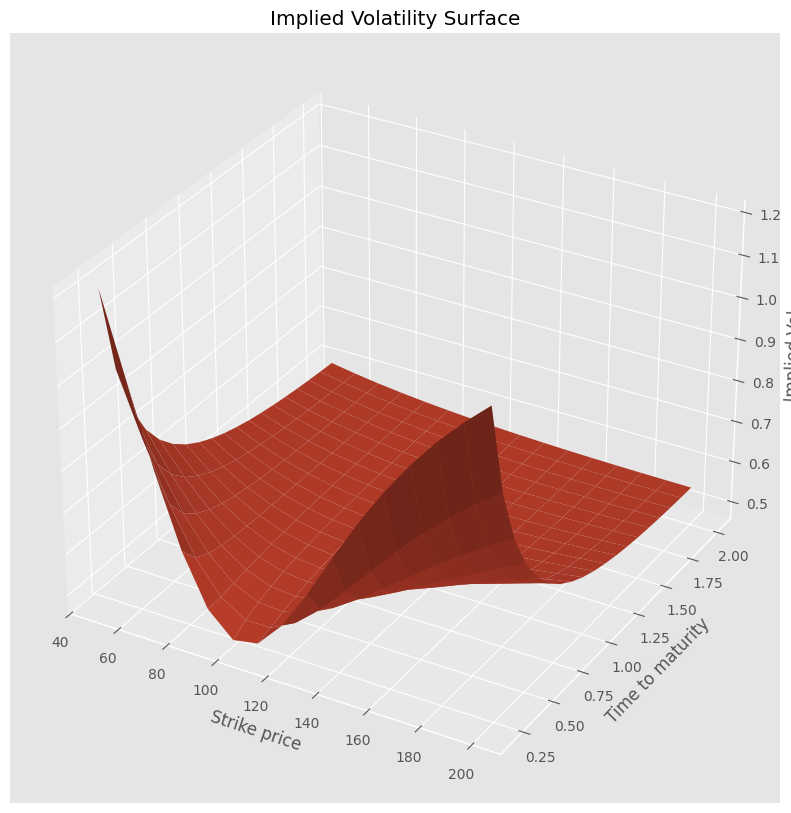

In [ ]:
# Test
params = [5, 0.4**2, 0.6**2, 1.0, -0.6] # = [kappa, nu0, theta, xi, rho]
S0 = 100
r = 0.05

k = np.arange(50, 210, 10) # strike prices
t = np.arange(0.2, 2.1, 0.1) # time to mat

# Define mesh
K, T = np.meshgrid(k, t)

# IV(Ki, Ti)
def IV_K_T(K_, T_):
    return ImpliedVol(Heston_price(S0, K_, T_, r, *params), S0, K_, r, T_, 10**-8, "call")

# IV in mesh
IV = np.array([IV_K_T(k_, t_)
            for kr, tr, in zip(K, T)
                for k_, t_, in zip(kr, tr) ]).reshape(len(K), len(K[0]))

fig = plt.figure(figsize=(30, 10))
ax = plt.axes(projection="3d")
ax.plot_surface(K, T, IV, rstride=1, cstride=1)
ax.set_xlabel("Strike price")
ax.set_ylabel("Time to maturity")
ax.set_zlabel("Implied Vol")
ax.set_title("Implied Volatility Surface")
plt.show()


In [ ]:
@widgets.interact(
    vol0 = (0.1, 0.5, 0.1), 
    volLT=(0.1, 0.5, 0.1), 
    kappa = (0.5, 2.0, 0.5), 
    rho = (-0.9, 0.9, 0.1), 
    xi = (0.1, 2.0, 0.1),
    T = ( 0.5, 5.0, 0.5)
    )


def plot(vol0 = 0.2, volLT = 0.3, kappa = 1.0, rho = -0.5, xi = 0.5, T = 0.5):
    params = [kappa, vol0**2, volLT**2, xi, rho]
    smile = []
    TS = []
    #S0 = 100
    r = 0.05
    fig, ax = plt.subplots(1, 2, figsize=(15,6))
    for K in np.arange(60, 150, 5):
        price = Heston_price(100, K, T, r, *params)
        IV = ImpliedVol(price, S0, K, r, T, 10**-8, "call")
        smile.append(100 * IV) # in percents
    #print(smile)

    for TT in np.arange(0.5, 5.5, 0.5):
        strike = 100.0
        price = Heston_price(100, strike, TT, r, *params)
        IV = ImpliedVol(price, S0, strike, r, TT, 10**-8, "call")
        TS.append(100 * IV)
    #print(TS)

    ax[0].plot(np.arange(60, 150, 5), smile, color="r", linewidth=3)
    #ax[0].set_ylim(0, 50)
    ax[0].grid(True)
    ax[0].set_title("Volatility Smile Heston")
    ax[0].set_xlabel('Strike')
    ax[0].set_ylabel('Implied Volatility (%)')
    
    ax[1].plot(np.arange(0.5, 5.5, 0.5), TS, color="b", linewidth = 3)
    #ax[1].set_ylim(0, 50)
    ax[1].grid(True)
    ax[1].set_title("Volatility Term Structure Heston")
    ax[1].set_xlabel("Time to Maturity")
    ax[1].set_ylabel("Implied Volatility (%)")
    #ax[1]=sns.histplot﴾Ret, kde=True,stat='density'﴿ #with Kernel density estimation
    plt.show()


: 

In [ ]:
r = 0.05
S0 = 100
IV = [0.28, 0.26, 0.245, 0.24, 0.242, 0.27, 0.26, 0.25, 0.245, 0.242, 0.265, 0.263, 0.26, 0.258, 0.257]
K = [95, 97.5, 100, 102.5, 105, 95, 97.5, 100, 102.5, 105, 95, 97.5, 100, 102.5, 105]
T = [0.25, 0.25, 0.25, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0]
Price = [call_price(S0, IV[i], K[i], T[i], r) for i in range(len(T))]

In [ ]:
#MSE between call prices
#params = [kappa, nu0, theta, xi, rho]
def MSE_Price(params):
    MSE_Price = 0
    for i in range(len(T)):
        MSE_Price = MSE_Price + (Heston_price(S0, K[i], T[i], r, *params) - Price[i])**2
    return MSE_Price / len(T)

#MSE between implied volatilities
def MSE_IV(params):
    MSE_IV = 0
    for i in range(len(T)):
        Price = Heston_price(S0, K[i], T[i], r, *params)
        HestonIV = ImpliedVol(Price, S0, K[i], r, T[i], 10**-8, "call")
        MSE_IV = MSE_IV + (HestonIV - IV[i])**2
    return MSE_IV / len(T)

#Constraints
cons=(
    {'type': 'ineq', 'fun': lambda x: 1.0 - x[4]}, #rho <= 1
    {'type': 'ineq', 'fun': lambda x: x[4] + 1.0}, #rho >= ­1
    {'type': 'ineq', 'fun': lambda x: x[3] - 0.00001}, #xi > 0
    {'type': 'ineq', 'fun': lambda x: x[0] - 0.00001}, #kappa > 0
    {'type': 'ineq', 'fun': lambda x: x[1] - 0.00001}, #nu0 > 0
    {'type': 'ineq', 'fun': lambda x: x[2] - 0.00001}, #theta > 0
    #Feller condition: 2 x kappa x theta ­ xi^2 > 0
    {'type': 'ineq', 'fun': lambda x: 2 * x[0] * x[2] - x[3]**2 - 0.00001}
)

### Minimising MSE between Market and Model Price

In [ ]:
warnings.filterwarnings('ignore')
#params = [kappa, nu0, theta, xi, rho]
params = [2.0, 0.25**2, 0.25**2, 0.5, -0.8] #initial params
result = minimize(MSE_Price, params, constraints = cons, method = 'SLSQP', tol=1e-6)
#print(result)

new_params = result['x']
new_params # [kappa, nu0, theta, xi, rho]

array([ 7.69554726,  0.05671207,  0.0724278 ,  1.05580926, -0.67632094])

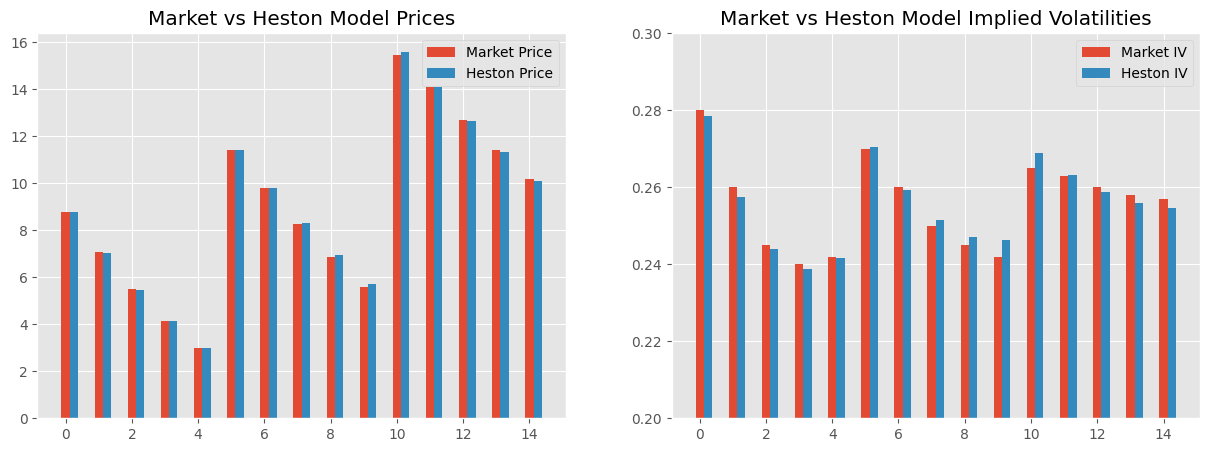

In [ ]:
Price_Heston = [Heston_price(S0, K[i], T[i], r, *new_params) for i in range(len(T))]
IV_Heston = [ImpliedVol(Price_Heston[i], S0, K[i], r, T[i], 10**-8, "call") for i in range(len(T))]

fig, axs = plt.subplots(1, 2, figsize=(15,5))
X = np.arange(15)

axs[0].bar(X, Price, width = 0.25)
axs[0].bar(X + 0.25, Price_Heston, width = 0.25)
axs[0].legend(labels=['Market Price', 'Heston Price'])
axs[0].set_title('Market vs Heston Model Prices')

axs[1].bar(X, IV, width = 0.25)
axs[1].bar(X + 0.25, IV_Heston, width = 0.25)
axs[1].legend(labels=['Market IV', 'Heston IV'])
axs[1].set_title('Market vs Heston Model Implied Volatilities')
axs[1].set_ylim([0.2, 0.3])

plt.show()

### Minimisation MSE between Market and Model Implied Volatilities

In [ ]:
warnings.filterwarnings('ignore')
params = [0.8, 0.25**2, 0.25**2, 0.5, -0.8] #initial params
result = minimize(MSE_IV, params, constraints = cons, method = 'SLSQP', tol=1e-10)

new_params = result['x']
new_params

array([ 0.80854795,  0.05751598,  0.10622214,  0.41166069, -0.79931765])

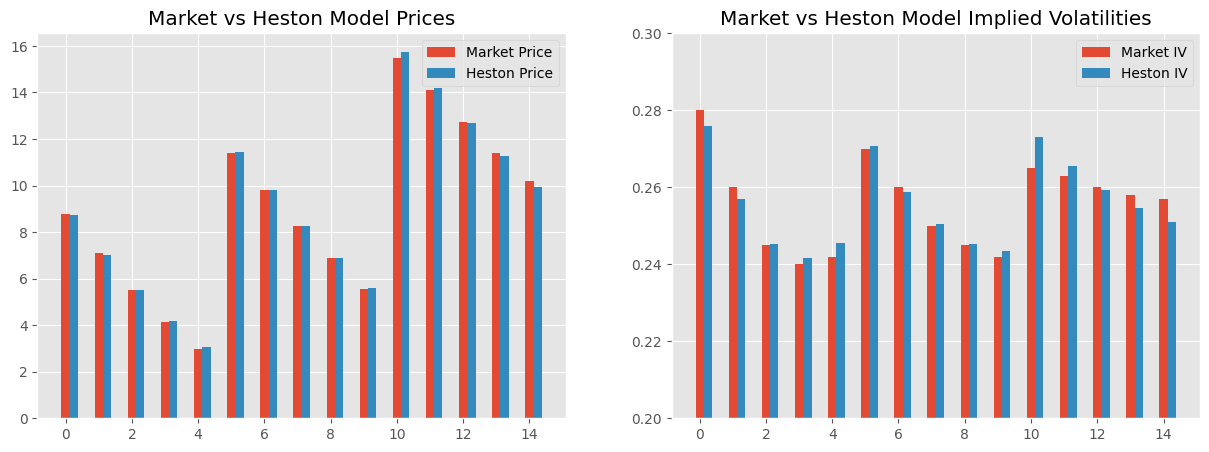

In [ ]:
Price_Heston = [Heston_price(S0, K[i], T[i], r, *new_params) for i in range(len(T))]
IV_Heston = [ImpliedVol(Price_Heston[i], S0, K[i], r, T[i], 10**-8, "call") for i in range(len(T))]

fig, axs = plt.subplots(1, 2, figsize=(15,5))
X = np.arange(15)

axs[0].bar(X, Price, width = 0.25)
axs[0].bar(X + 0.25, Price_Heston, width = 0.25)
axs[0].legend(labels=['Market Price', 'Heston Price'])
axs[0].set_title('Market vs Heston Model Prices')

axs[1].bar(X, IV, width = 0.25)
axs[1].bar(X + 0.25, IV_Heston, width = 0.25)
axs[1].legend(labels=['Market IV', 'Heston IV'])
axs[1].set_title('Market vs Heston Model Implied Volatilities')
axs[1].set_ylim([0.2, 0.3])

plt.show()

#### Calibration of Heston model using COS method
Let us repeat the same procedure with COS method and compare the option prices using midpoint, COS method, Monte Carlo (with Black-Scholes value). 

- We expect the procedure to be much more efficient, i.e. the optimisation part can run fast.